Wavefront Sensing 

In [1]:
import pandas as pd
import sympy as sp
import numpy as np
import math
import scipy as spy
import scipy.special as special
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit

from sympy import Symbol 
from sympy import symbols 
from sympy import *
from sympy import Integral, oo, exp, pi, integrate
from sympy import oo
from sympy import sinc
infinity=oo
k,a,y,f,phi = symbols("k,a,y,f,phi")
init_printing(use_unicode=False, wrap_line=False)

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Part 1 - Obtaining the power via integrating the intensity on the detectors, found from Fourier-Transforming a top-hat function input electric field through a single slit aperture in y. The intensity is the following integrand, in units of Watts/Meter due to being in 1D (y)

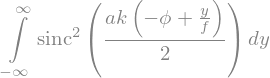

In [2]:
#Setting up power integral
integrate((sinc(k*a/2*(y/f-phi)))**2,(y,-infinity,infinity))

Import .txt file for wavefront data

Enter radius of curvature [mm]-26.2
Enter initial width of the beam [mm].2
0.00021255602340417628
0.0001728046750901636 end
0.0001728046750901636 end


<Figure size 432x288 with 0 Axes>

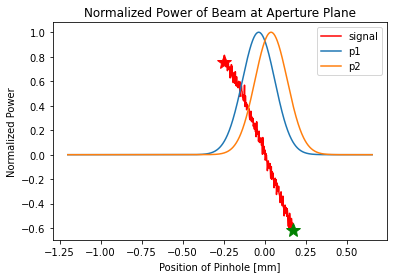

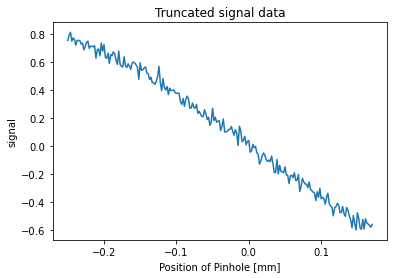

<Figure size 432x288 with 0 Axes>

In [11]:
#Created simulated data
#Parameters
T = 1000 #Times for length of data
time = np.linspace(0,100e-6,T) #Total time data gathered (seconds)
r = 73.15e-3 #radial distance from center aperture to center pinhole (meters)
period = 24.8e-3 #time for of pinhole to complete one cycle in angular displacement (seconds)
omega = 2*np.pi/period #angular velocity of pinhole
v = r*omega #linear velocity along aperture plane (y) (m/s)
Lambda = 632.8e-9 #wavelength of laser (meters)

R = 1e-3*eval(input('Enter radius of curvature [mm]')) #radius curvature converted to mm with 1e-3 factor
w0 = 1e-3*eval(input('Enter initial width of the beam [mm]')) #width @ z=0 converted to mm

f = 35e-3 #m
d2 = 14e-3 #m
d1 = 267e-3 #m
n = 1 #Index of refraction
A = 1 - d2/f
B = (1-d2/f)*d1 + d2
C = -1/f
D = 1 - d1/f
z_R = np.pi* w0**2 * n/Lambda #Rayleigh range
#w2 = w0*(d1/f-1)**(-1)*(1+(z_R/(d1-f))**2)**(-1/2) #width at aperture plane
z = 0
w2 = float(sqrt(Lambda/np.pi)*sqrt(((A*z+B)**2+(A*z_R)**2)/(A*z_R*(C*z+D)-C*z_R*(A*z+B))))
print(w2)

k=2*np.pi/(Lambda) #wave number (in inverse meters)
a=1e-5 #diameter of aperture (in meters)
f=0.125 #focal length of 125 mm lens between aperture plane and detector plane (in meters)

#Define our intensity function
def sinc_int(y, a, k, f, phi):
    return  special.sinc(k*(a/2)*(y/f-phi))**2


y0 = -1.2e-3 #estimated starting position of pinhole at aperture plane (below y = 0)
angle = (y0+v*time)/R #phi = y/R, where y along aperture plane is expressed as a function of time
angle = angle.reshape(T) #reshape array from 'ket' to 'bra' to use in upcoming loop
ylim = 1e-2 #distance to edge of detector (in meters)

#Create empty arrays of length T (number of data points detector reads)
sig1 = np.zeros(T) #detector 1 zero array to fill in for-loop
sig2 = np.zeros(T) #detector 2 array 

#Creating simulated data expected on the detectors
for i in range(T):
    phi = angle[i] #current tilt angle being fed into power integrals
    
    #integrals for detector 1 and 2 take in each tilt angle, and give a power value
    signal1 = quad(sinc_int, 0, ylim, args=(a,k,f,phi)) #power detector 1 - prints tuple!
    signal2 = quad(sinc_int, -ylim, 0, args=(a,k,f,phi)) #power detector 2
  
    #Localized plane wave has an amplitude at y, or R*angle[i], on the gaussian beam
    sig1[i] = np.exp(-2*(R*angle[i]/w2)**2)*signal1[0] #Extracts first element of the two-element tuple generated from quad
    sig2[i] = np.exp(-2*(R*angle[i]/w2)**2)*signal2[0]


#Adding noise to the data
mu, sigma = 0, 1/sqrt(2*np.pi) #mean and standard deviation on gaussian distribution
dy = 3e-2*np.random.normal(mu,3*sigma,T) #Creates an array of random values from less than 1


p1data = sig1/max(sig1) #normalized power reading on detector 1
p2data = sig2/max(sig2) #detector 2 power


#Determining end and start markers for data cutoff point
count = 0
def find_start(arr):
    for i in range(len(arr)):
        if arr[i] <= 0.10*arr.max(): #at 10% max power, the loop stops and marks start
            continue
        else:
            n = i #returns index of position on aperture planne
            count = R*angle[i] #returns position on aperture plane
            break
    return n, count #returns a tuple (a list) which must be indexed

count2 = 0
def find_end(arr):
    for j in range(len(arr)):
        if arr[j+arr.argmax()] >= 0.10*arr.max(): #after peak, at 10% max power, marks end
            continue
        else:
            m = j + arr.argmax()
            count2 = R*angle[j+arr.argmax()] 
            print(count2,'end')
            break
    return m, count2

#Extracting the values of each tuple from "start/end finder" function
start = find_start(p1data)[1]
end = find_end(p1data)[1]
n = find_start(p1data)[0]
m = find_end(p1data)[0]


signal_data = (p1data-p2data)/(p1data+p2data) + dy #adds noise to signal

'''
We can choose to add noise to p1data and p2data here, however, adding noise
before signal_data causes significant error in plot. To add noise, remove
hashtag in front of p1data and p2data below
'''

#p1data = p1data + dy
#p2data = p2data + dy

position = 1e3*(R*angle) #converts x-axis from time to position in [mm]

#Observe signal with a plot to find meaningful data
plt.plot(position[n:m],signal_data[n:m],'r-')
plt.plot(position,p1data)
plt.plot(position,p2data)
plt.legend(['signal','p1','p2'])
plt.xlabel(r'Position of Pinhole [mm]')
plt.ylabel(r'Normalized Power' )
        
#Plot truncated signal
plt.plot(position[n],signal_data[n], '*r', ms = 15)
plt.plot(position[m],signal_data[m], '*g', ms = 15)
plt.title('Normalized Power of Beam at Aperture Plane')
plt.figure()

#Plot of truncated signal extracted from raw data
plt.plot(position[n:m],signal_data[n:m])
plt.ylabel('signal')
plt.xlabel('Position of Pinhole [mm]')
plt.title('Truncated signal data')
plt.figure()



Generate an N array of signal values given N-angles $\phi$

In [12]:
#N should match the number of data points acquired from experiment
N = m - n

angle = np.linspace(-.02,.02,N).reshape(N)
power_plt = np.zeros(N)

for i in range(N):
    phi = angle[i] #current tilt angle being fed into power integrals
    sig1 = quad(sinc_int, 0, infinity, args=(a,k,f,phi)) #power detector 1
    sig2 = quad(sinc_int, -infinity, 0, args=(a,k,f,phi)) #power detector 2
    power_plt[i] = (sig1[0] - sig2[0])/(sig1[0]+sig2[0]) #normalized signal



    
print(power_plt)

<ipython-input-12-e000318edc88>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sig1 = quad(sinc_int, 0, infinity, args=(a,k,f,phi)) #power detector 1
<ipython-input-12-e000318edc88>:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

[-0.90294621 -0.90294841 -0.90295026 -0.90293044 -0.90291657 -0.90287727
 -0.90282135 -0.90274424 -0.90264156 -0.90250948 -0.9023441  -0.90214136
 -0.90183189 -0.90160707 -0.90126688 -0.90087205 -0.900418   -0.89981624
 -0.8992822  -0.89858086 -0.89784245 -0.89702002 -0.8961752  -0.89517165
 -0.89406945 -0.8928593  -0.89152814 -0.89011676 -0.88854923 -0.88687572
 -0.88507126 -0.88313226 -0.88105192 -0.8788229  -0.87644756 -0.87390868
 -0.87121248 -0.86834963 -0.86531885 -0.86210686 -0.85870812 -0.85502482
 -0.85135902 -0.84738613 -0.84321658 -0.83884172 -0.83425724 -0.82946432
 -0.82444439 -0.8192086  -0.81374865 -0.80805191 -0.80212687 -0.79597559
 -0.78957422 -0.78293015 -0.77603402 -0.76890294 -0.76151911 -0.75387424
 -0.74598881 -0.73784028 -0.72944914 -0.72079151 -0.71187259 -0.70269934
 -0.69327412 -0.68362552 -0.67367639 -0.66346819 -0.65300154 -0.64227731
 -0.63129665 -0.62006097 -0.60851764 -0.59679272 -0.58483923 -0.57260024
 -0.56012281 -0.54734629 -0.53438577 -0.52124536 -0

Enter total signal power measured on both detectors between 
 -0.9029462142935973 and 0.9029462142935973 .5
(0.49412311678616716, 0.5077714273178009, 144, 145)
The closest value to 0.5 is [0.49412311678616716, 0.5077714273178009]
The phase gradient is at 0.005450324967344018 rad.


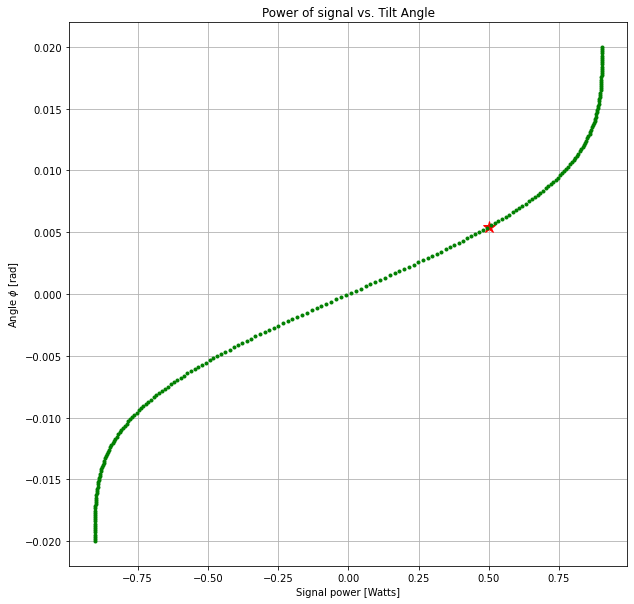

In [13]:
#Interpolation scheme to pick out phase gradient, phi
def closest_values(input_array, input_value):
        arr = input_array #Takes in power values s = p1-p2
        k = (np.abs(arr - input_value)).argmin() #Index of smallest difference, to left.
        if input_value < arr[k]:
            k = k-1
        j = k+1
        return arr[k],arr[j],k,j #returns 4-element tuple 
        
#Enter your measured power on the detectors

p_new = eval(input('Enter total signal power measured on both detectors between \n '
                    + str(power_plt[0]) + ' and ' + str(power_plt[-1]) + ' '))
                                                                                                                               
print(closest_values(power_plt,p_new))
p=list(closest_values(power_plt,p_new))[0:2] #Picks out first two values of Tuple 
print("The closest value to "+ str(p_new)+" is",p)

#p = list(closest_values(power_plt,p_new))[0:2] #Turns first two tuple elements into list
k,j = list(closest_values(power_plt,p_new))[2:] #Turns last two tuple elements into list (indices)
#p = [power_plt[k],power_plt[j]]
ang = [angle[k], angle[j]] #phi at same indices as power


a_new = np.interp(p_new, p, ang) #Use numpy interp function to create estimated phi
print('The phase gradient is at',a_new,'rad.')
#End of interpolation scheme

#Plot phi(power) 
plt.figure(figsize=(10,10))
plt.plot(p, ang, "g-", p_new, a_new, '*r',markersize=12) #plots interpolation line and point
plt.plot(power_plt,angle,'g.') #plots data of N points
plt.grid(True)
plt.title('Power of signal vs. Tilt Angle')
plt.ylabel(r'Angle $\phi$ [rad]')
plt.xlabel('Signal power [Watts]')
plt.show()

Part 2 - We just retrieved the phase gradient $\phi (p)$ of a single piece of the gaussian wavefront diffracting through a single slit aperture. We need to infer the phase gradient of every piece from our new signal power function.

[-0.90294621 -0.90294841 -0.90295026 -0.90293044 -0.90291657 -0.90287727
 -0.90282135 -0.90274424 -0.90264156 -0.90250948 -0.9023441  -0.90214136
 -0.90183189 -0.90160707 -0.90126688 -0.90087205 -0.900418   -0.89981624
 -0.8992822  -0.89858086 -0.89784245 -0.89702002 -0.8961752  -0.89517165
 -0.89406945 -0.8928593  -0.89152814 -0.89011676 -0.88854923 -0.88687572
 -0.88507126 -0.88313226 -0.88105192 -0.8788229  -0.87644756 -0.87390868
 -0.87121248 -0.86834963 -0.86531885 -0.86210686 -0.85870812 -0.85502482
 -0.85135902 -0.84738613 -0.84321658 -0.83884172 -0.83425724 -0.82946432
 -0.82444439 -0.8192086  -0.81374865 -0.80805191 -0.80212687 -0.79597559
 -0.78957422 -0.78293015 -0.77603402 -0.76890294 -0.76151911 -0.75387424
 -0.74598881 -0.73784028 -0.72944914 -0.72079151 -0.71187259 -0.70269934
 -0.69327412 -0.68362552 -0.67367639 -0.66346819 -0.65300154 -0.64227731
 -0.63129665 -0.62006097 -0.60851764 -0.59679272 -0.58483923 -0.57260024
 -0.56012281 -0.54734629 -0.53438577 -0.52124536 -0

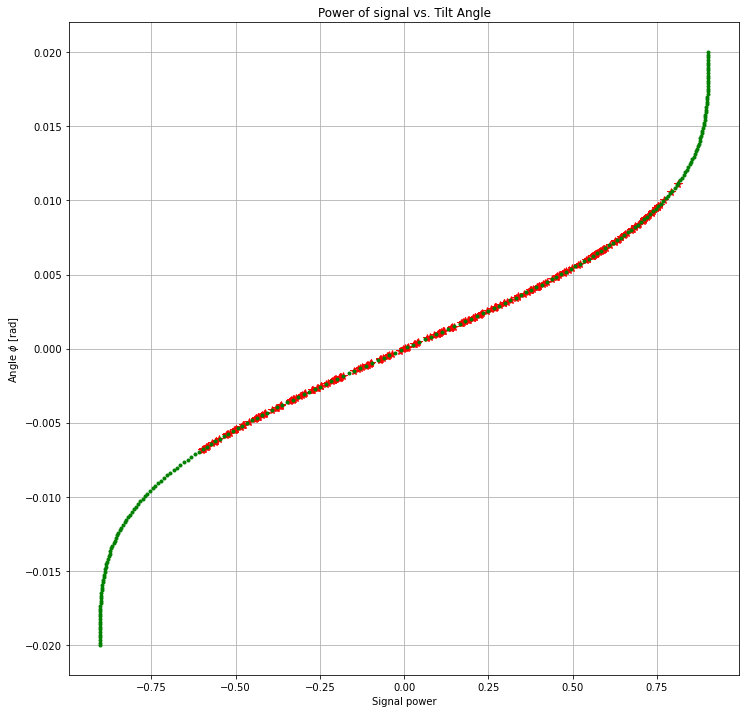

Text(0.5, 0, 'Data points')

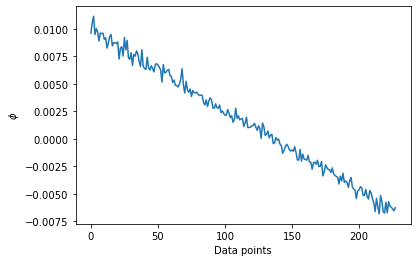

In [14]:
#Interpolating between every data point
    
print(power_plt)
a_new = np.zeros(N)
p_new = np.zeros(N)

for i in range(N):
   
    #p_new is the interpolated signal to produce an angle, phi
    #data[:,5] is the truncated data for signal acquired in column 6 in the .txt/.xls file
    
    p_new[i] = signal_data[i+n]
                                                                                                                   
    #Find closest two power data points to interpolate between

    print(closest_values(power_plt,p_new[i]))
    if p_new[i] == 0:
        a_new[i] = 0
        continue
    p=list(closest_values(power_plt,p_new[i]))[0:2] #Picks out first two values of Tuple 
    print("The closest values to "+ str(p_new[i])+" is",p)

    #p = list(closest_values(power_plt,p_new))[0:2] #Turns first two tuple elements into list
    k,j = list(closest_values(power_plt,p_new[i]))[2:] #Turns last two tuple elements into list (indices)
    #p = [power_plt[k],power_plt[j]]
    ang = [angle[k], angle[j]] #phi at same indices as power

    
    a_new[i] = np.interp(p_new[i], p, ang) #Use numpy interp function to create estimated phi

    
    
print(a_new)
#Plot phi(power)

#Plot phi(power) 
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(12,12))
plt.plot(p, ang, "g-", p_new, a_new, '*r',markersize=8) #plots interpolation line and point
plt.plot(power_plt,angle,'g.') #plots data of N points
plt.grid(True)
plt.title('Power of signal vs. Tilt Angle')
plt.ylabel(r'Angle $\phi$ [rad]')
plt.xlabel('Signal power')
plt.show()
plt.figure()
plt.plot(a_new)
plt.ylabel(r'$\phi$')
plt.xlabel('Data points')

1. Create curve-fit functions and apply to $\phi (t)$ data to obtain R
2. Create a plot of $\Delta z$ vs. t with obtained radius of curvature, R
3. Apply curve-fit with noise to data, and perform linear regression. Since 
$\phi = \frac{d\Delta z}{dt}$, the quadratic $\Delta z$ has a derivative that is linear.

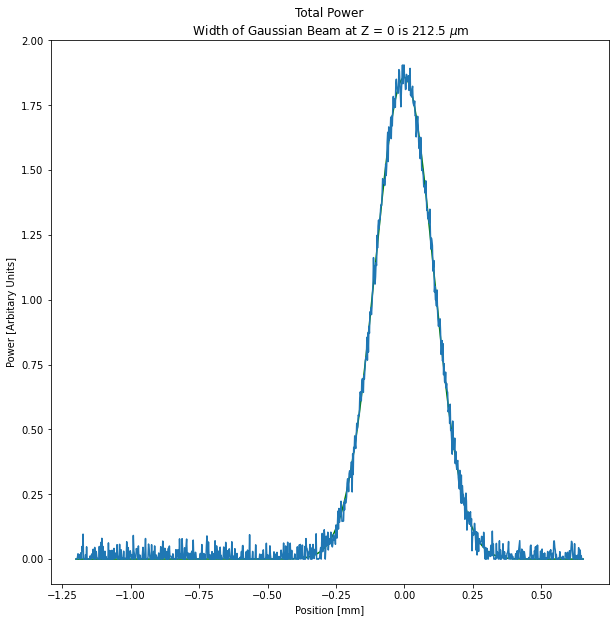

In [15]:
#Acquire total power, p1+p2
mu, sigma = 0, 1/sqrt(2*np.pi) #mean and standard deviation on gaussian distribution
dy = 3e-2*np.random.normal(mu,3*sigma,T)
totalpower = np.array(p1data + p2data + dy) #add noise with random array 'dy'

#Filter totalpower data by removing any values below zero
for i in range(len(totalpower)):
    if totalpower[i] <= 0:
        totalpower[i] = 0

T = len(totalpower) #Times for length of data
t = np.linspace(0,100e-6,T) #Normalized time with T data points (seconds)
v = r*omega #velocity of the moving aperture m/s 

#Waist as a fuction of z
def w02(wap):
    return wap**2 - (Lambda*z/np.pi)**2

#Theoretical power curve
def Power(t,E_0,y0,w):
    p = E_0**2 * np.e**(-2*((y0+v*t)/(w))**2)
    return p

#fitting the gaussian
from scipy.optimize import curve_fit 

parameters, covariance = curve_fit(Power, t, totalpower) 

#obtains fitted parameters (all parameters after first variable 't')
E_0 = parameters[0]  #electric field amplitude
y0 = parameters[1] #initial position on aperture plane
wap = parameters[2] #waist of beam

#z_R = np.pi* w0**2 * n/Lambda #Rayleigh range
z = 0

#Use fit parameters from curve-fit to substitute into power function
fit_y = Power(t,E_0, y0,wap)

#Changes the amplitude to match data amplitude
#Gauss_fit = fit_y*(1-abs(max(totalpower)-max(Power(t,E_0,y0,w0)))/max(Power(t,E_0, y0, w0)))

#Plot phi(power) 
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,10))
plt.plot(position, fit_y, "g-") #plots fit
plt.plot(position,totalpower) #plots p1 + p2 data with noise
plt.title(r'Total Power' +
          '\n Width of Gaussian Beam at Z = ' + str(z) + ' is ' + str(1e6*round(wap,7)) + r' $\mu$m')
plt.ylabel(r'Power [Arbitary Units]')
plt.xlabel(r'Position [mm]')
plt.show()

In [16]:
#Curve-fitting functions for both linear regression and polynomials
from pylab import *
import matplotlib.pyplot as plt
import numpy as np



def dinput(input_text) :
    return int(input(input_text))

def finput(input_text) :
    return float(input(input_text))

def ainput(input_prompt) :
    '''
    Function to convert user input of a list or tuple of values to a numpy array.
    Input format can be like "1,2" or "[1,2]" or "(1,2)" etc
    '''
    return(array(eval(input(input_prompt))))

def linreg(x,y,sigma):
    """Function to perform linear regression (fit a line)
       Inputs
        x       Independent variable
        y       Dependent variable
        sigma   Estimated error in y
       Outputs
        a_fit   Fit parameters; a(1) is intercept, a(2) is slope
        sig_a   Estimated error in the parameters a()
        yy      Curve fit to the data
        chisqr  Chi squared statistic
    """
    
    #* Evaluate various sigma sums
    s = 0.; sx = 0.; sy = 0.; sxy = 0.; sxx = 0.
    for i in range(len(x)):
        sigmaTerm = sigma[i]**(-2)
        s += sigmaTerm              
        sx += x[i] * sigmaTerm
        sy += y[i] * sigmaTerm
        sxy += x[i] * y[i] * sigmaTerm
        sxx += x[i]**2 * sigmaTerm
    denom = s*sxx - sx**2

    #* Compute intercept a_fit(1) and slope a_fit(2)
    a_fit = np.empty(2)
    a_fit[0] = 0#(sxx*sy - sx*sxy)/denom
    a_fit[1] = (s*sxy - sx*sy)/denom

    #* Compute error bars for intercept and slope
    sig_a = np.empty(2)
    sig_a[0] = np.sqrt(sxx/denom)
    sig_a[1] = np.sqrt(s/denom)

    #* Evaluate curve fit at each data point and compute Chi^2
    yy = np.empty(len(x))
    chisqr = 0.
    for i in range(len(x)):
        yy[i] = a_fit[0] + a_fit[1]*x[i]          # Curve fit to the data
        chisqr += ((y[i]-yy[i])/sigma[i] )**2    # Chi square
    return [a_fit, sig_a, yy, chisqr]

def pollsf(x, y, sigma, M):
    """Function to fit a polynomial to data
       Inputs 
        x       Independent variable
        y       Dependent variable
        sigma   Estimate error in y
        M       Number of parameters used to fit data
       Outputs
        a_fit   Fit parameters; a(1) is intercept, a(2) is slope
        sig_a   Estimated error in the parameters a()
        yy      Curve fit to the data
        chisqr  Chi squared statistic
    """

    #* Form the vector b and design matrix A   
    N = len(x)
    b = empty(N)
    A = empty((N,M))
    #print(A)
    for i in range(N):
        b[i] = y[i]/sigma[i]
        for j in range(1,M):
            A[i,j] = x[i]**(j) / sigma[i]

    #* Compute the correlation matrix C 
    C = inv( transpose(A) @ A )

    #* Compute the least squares polynomial coefficients a_fit
    a_fit = C @ ( transpose(A) @ transpose(b) ) 

    #* Compute the estimated error bars for the coefficients
    sig_a = empty(M)
    for j in range(1,M):
        sig_a[j] = sqrt(C[j,j])

    #* Evaluate curve fit at each data point and compute Chi^2
    yy = zeros(N)
    chisqr = 0
    for i in range(N):
        for j in range(1,M):
    
            yy[i] += a_fit[j]*x[i]**(j)  # yy is the curve fit
      
        chisqr += ((y[i]-yy[i]) / sigma[i])**2
        
        
    return [a_fit, sig_a, yy, chisqr]

Fit parameters:
a[0] = 0.000000000000000 +/- 0.00000
a[1] = -39.205377559908605 +/- 0.00000
polyval best-fit parameters:  [-3.92053776e+01  9.51986843e-05]
parameter uncertainties:  [2.32089764e-01 2.98453390e-05]
Chi-square: 43811597323959.86


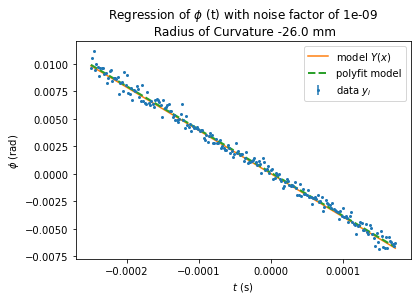

In [17]:
#We feed a_new, our acquired phi(t) angle array, into a polynomial least squares fit
#to acquire the Radius of Curvature

yprime = np.linspace(start,end,len(a_new)) #milliseconds
    
x = yprime
y = a_new
dy = 1e-9*np.ones(len(yprime))
seed(0)           # Initialize random number generator
y += normal(0,dy) # add simulated measurement errors (Gaussian distributed random vector)

#* Fit the data to a straight line or a more general polynomial
M = 2
if M == 2 :  
    #* straight line fit
    [a_fit, sig_a, yy, chisqr] = linreg(x, y, dy)
else: 
    #* Polynomial fit
    [a_fit, sig_a, yy, chisqr] = pollsf(x, y, dy, M)

#* Print out the fit parameters, including their error bars.
print('Fit parameters:')
for i in range(M):
    print('a[%d] = %.15f +/- %.5f' % (i,a_fit[i],sig_a[i]))

# Use built-in numpy function:
deg = M - 1
params, cov = polyfit(x,y,deg,w=1/dy,cov=True)
dparams = sqrt( diag( cov ))
print('polyval best-fit parameters: ', params)
# variance in parameters from diagonal of covariance matrix:
print('parameter uncertainties: ', dparams)
print('Chi-square:', chisqr)


#Define our phi(t) parabola for given Radius of Curvature above
#Compare this with our calculated phi values above (in array a_new)
R = 1/a_fit[1]

# construct best-fitting model
xmod = linspace(min(x),max(x),100)
ymod = polyval(params,xmod)
#rcParams.update({'font.size': 20})
#* Graph the data, with error bars, and fitting function.
plt.figure()
plt.errorbar(x,y,dy,fmt='o',ms=2,label='data $y_i$')   # Graph data with error bars
plt.plot(x,yy,'-',label='model $Y(x)$')            # Plot the fit on same graph as data
plt.plot(xmod,ymod,'--',lw=2,label='polyfit model') # polyfit result
plt.title(r'Regression of $\phi$ (t) with noise factor of ' + str(dy[0]) + 
          '\n Radius of Curvature ' + str(1e3*round(R,3)) + ' mm')
#plt.title('Projectile Motion: ') + air_text)
xlabel('$t$ (s)')  
ylabel(r'$\phi$ (rad)')
legend(loc='best')
#speeds = r'$v_0$ = {0:.1f} '.format(speed)



#tick_params('both', length=8, width=1.2, which='major') # bigger axis ticks
plt.show()



Text(0, 0.5, 'Percent of a wavelength (632.8 nm)')

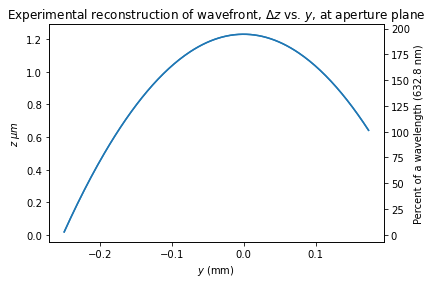

<Figure size 432x288 with 0 Axes>

In [18]:
wavefront = []
delta_t = (t[m] - t[n])/len(a_new) #end - start of time wavefront is scanned by pinhole
                                   #divided by total number of data points
delta_y = v*delta_t #acquire finite 'dy' element in summation as 'delta_y' 

z = 0
for i in range(len(a_new)):
    
    #each position z on wavefront is angle element yy[i]
    #multiplied by evenly spaced intervals of delta_y
    z += yy[i]*delta_y 
    wavefront.append(1e6*z) #converting to micrometers

y = y0 + v*np.linspace(t[n],t[m],len(a_new)) #time to position conversion on aperture plane
y = 1e3*y #change units m ---> mm


fig, ax1 = plt.subplots()

y2 = np.array(wavefront)/(1e6*Lambda)*100 #percent of a full wavelength (0.630 micrometers)

ax2 = ax1.twinx() #creates secondary z-axis

plt.figure()
ax1.plot(y,wavefront,'-') #reconstructed wavefront
ax2.plot(y,y2) #scales secondary z-axis
ax1.set_title(r'Experimental reconstruction of wavefront, $\Delta z$ vs. $y$, at aperture plane')
ax1.set_xlabel('$y$ (mm)')  
ax1.set_ylabel(r'$z$ $\mu m$')
ax2.set_ylabel(r'Percent of a wavelength (' + str(1e9*Lambda) + ' nm)')

